In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from google.colab import files
import time
import math
from matplotlib.lines import Line2D
from shapely.geometry import Polygon
from shapely.ops import transform, cascaded_union
import pyproj
import numpy as np

Saving data.csv to data (1).csv


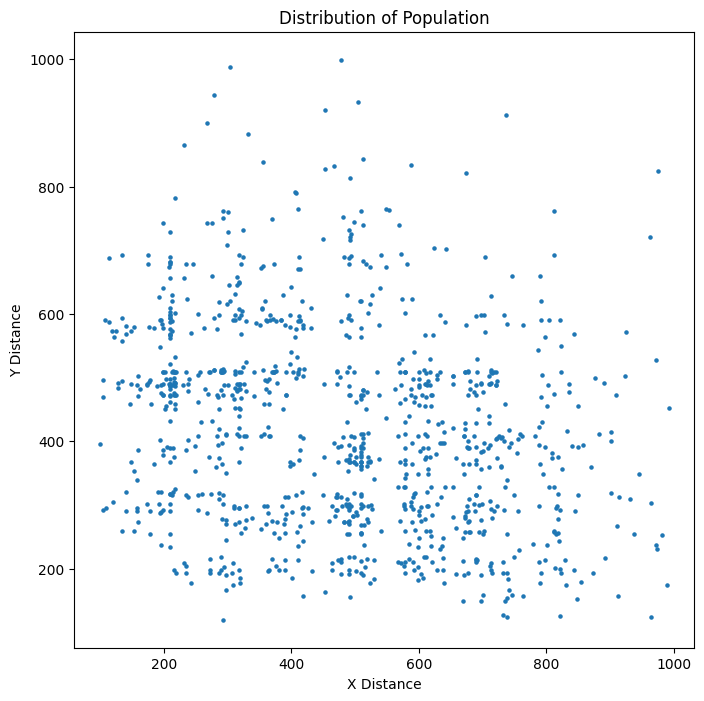

Total data points: 1014


In [27]:
uploaded = files.upload()
data = pd.read_csv('data.csv')
np.random.seed(42)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data['x'], data['y'], s=5)
ax.set_title('Distribution of Population')
ax.set_xlabel('X Distance')
ax.set_ylabel('Y Distance')
ax.set_aspect('equal', adjustable='datalim')
plt.show()

total_data_points = len(data)
print(f"Total data points: {total_data_points}")

In [28]:
def optimal_eps(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)

    plt.plot(distances)
    plt.title('k-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.show()
    return distances

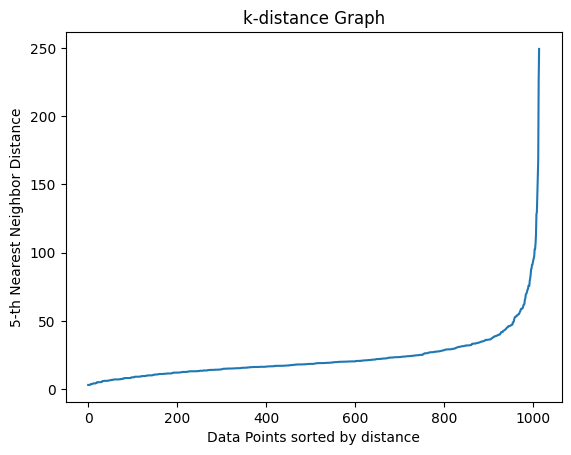

Optimal eps (approx.): 38.47076812334269


In [29]:
k = 5
distances = optimal_eps(data[['x', 'y']], k)
optimal_eps = distances[int(len(distances) * 0.9)]
print(f"Optimal eps (approx.): {optimal_eps}")


In [30]:
def dbscan(X, eps, min_samples, max_points_per_cluster):
    def split_clusters(X, labels, eps, min_samples, max_points_per_cluster):
        unique_labels = set(labels)
        new_labels = labels.copy()
        next_label = max(labels) + 1
        for label in unique_labels:
            if label == -1:
                continue
            points_in_cluster = X[labels == label]
            if len(points_in_cluster) > max_points_per_cluster:
                sub_db = DBSCAN(eps=eps/2, min_samples=min_samples)
                sub_labels = sub_db.fit_predict(points_in_cluster)
                sub_labels[sub_labels != -1] += next_label
                new_labels[labels == label] = sub_labels
                next_label = max(new_labels) + 1
        return new_labels

    db = DBSCAN(eps=eps, min_samples=min_samples)
    start_time = time.time()
    labels = db.fit_predict(X)
    end_time = time.time()
    while np.any(np.bincount(labels[labels != -1]) > max_points_per_cluster):
        labels = split_clusters(X, labels, eps, min_samples, max_points_per_cluster)
    print(f"Time for clustering: {end_time - start_time:.4f} seconds")
    return labels



In [31]:
def reclassify_noise_points(X, labels):
    noise_points = X[labels == -1]
    core_points = X[labels != -1]
    core_labels = labels[labels != -1]
    if len(noise_points) == 0:
        return labels
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(core_points)
    distances, indices = neigh.kneighbors(noise_points)
    new_labels = labels.copy()
    new_labels[labels == -1] = core_labels[indices.flatten()]
    return new_labels

In [32]:
def calculate_centroids(X, labels):
    unique_labels = set(labels)
    centroids = []
    for label in unique_labels:
        if label == -1:
            continue
        points_in_cluster = X[labels == label]
        centroid = np.mean(points_in_cluster, axis=0)
        centroids.append((label, centroid))
    return centroids


In [33]:
def buffered_hull(points, buffer_distance=0.05):
    if len(points) < 3:
        return Polygon(points).buffer(buffer_distance)
    hull = ConvexHull(points)
    poly_points = points[hull.vertices]
    polygon = Polygon(poly_points)
    return polygon.buffer(buffer_distance)

In [52]:

min_samples = k
max_points_per_cluster = 100
X = data[['x', 'y']].values
labels = dbscan(X, optimal_eps, min_samples, max_points_per_cluster)
labels = reclassify_noise_points(X, labels)
centroids = calculate_centroids(X, labels)
unique_labels = set(labels)


Time for clustering: 0.0085 seconds


<ipython-input-35-4d1759a4b7e4>:19: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='x', edgecolors='w', zorder=5)


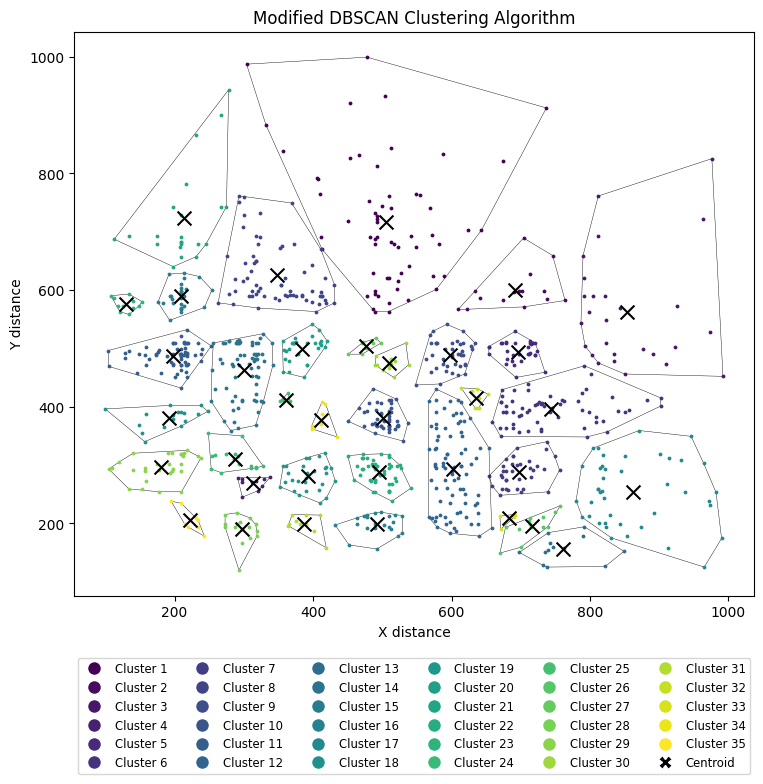

In [35]:
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 8))
legend_elements = []

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data[class_member_mask]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col, markersize=10, label=f'Cluster {k}'))

    if len(xy) > 2:
        hull_polygon = buffered_hull(xy.values)
        if hull_polygon.is_valid:
            x, y = hull_polygon.exterior.xy
            plt.plot(x, y, 'k-', linewidth=0.3)

    plt.plot(xy['x'], xy['y'], '.', markerfacecolor=tuple(col), markersize=5.5, markeredgewidth=0)

for label, centroid in centroids:
    plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='x', edgecolors='w', zorder=5)

legend_elements.append(Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10, label='Centroid'))
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize='small', ncol=6)
plt.title('Modified DBSCAN Clustering Algorithm')
plt.xlabel('X distance')
plt.ylabel('Y distance')
plt.tight_layout()
plt.show()

In [36]:
max_lines = 9
print_data = [f"Cluster {label}: {sum(labels == label)} data points" for label in unique_labels if label != -1]
formatted_output = [""] * max_lines
for i, line in enumerate(print_data):
    column_index = i // max_lines
    row_index = i % max_lines
    formatted_output[row_index] += f"{line:<30}"
print("\nDATA POINTS PER CLUSTER:")
for line in formatted_output:
    print(line)



DATA POINTS PER CLUSTER:
Cluster 1: 62 data points     Cluster 10: 46 data points    Cluster 19: 28 data points    Cluster 28: 16 data points    
Cluster 2: 15 data points     Cluster 11: 65 data points    Cluster 20: 29 data points    Cluster 29: 29 data points    
Cluster 3: 27 data points     Cluster 12: 84 data points    Cluster 21: 22 data points    Cluster 30: 14 data points    
Cluster 4: 10 data points     Cluster 13: 13 data points    Cluster 22: 47 data points    Cluster 31: 10 data points    
Cluster 5: 32 data points     Cluster 14: 68 data points    Cluster 23: 11 data points    Cluster 32: 8 data points     
Cluster 6: 62 data points     Cluster 15: 28 data points    Cluster 24: 16 data points    Cluster 33: 6 data points     
Cluster 7: 36 data points     Cluster 16: 22 data points    Cluster 25: 5 data points     Cluster 34: 8 data points     
Cluster 8: 66 data points     Cluster 17: 42 data points    Cluster 26: 13 data points    Cluster 35: 8 data points     
Cluste

In [25]:
max_lines = 12
print_data = [f"Cluster {label}: {centroid}" for label, centroid in centroids]
formatted_output = [""] * max_lines
for i, line in enumerate(print_data):
    column_index = i // max_lines
    row_index = i % max_lines
    formatted_output[row_index] += f"{line:<45}"
print("\nCENTROIDS OF THE CLUSTERS:")
for line in formatted_output:
    print(line)



CENTROIDS OF THE CLUSTERS:
Cluster 1: [505.48387097 715.77419355]       Cluster 13: [760.46153846 155.69230769]      Cluster 25: [361.  412.2]                    
Cluster 2: [691.66666667 600.33333333]       Cluster 14: [300.29411765 462.70588235]      Cluster 26: [716.07692308 195.61538462]      
Cluster 3: [853.88888889 562.66666667]       Cluster 15: [208.89285714 589.39285714]      Cluster 27: [477.125 504.375]                
Cluster 4: [313.  268.9]                     Cluster 16: [492.         198.45454545]      Cluster 28: [296.8125 189.75  ]              
Cluster 5: [695.84375 494.40625]             Cluster 17: [861.61904762 253.19047619]      Cluster 29: [180.51724138 296.86206897]      
Cluster 6: [744.08064516 395.43548387]       Cluster 18: [192.11764706 380.52941176]      Cluster 30: [510.35714286 474.85714286]      
Cluster 7: [697.05555556 287.61111111]       Cluster 19: [393.32142857 280.53571429]      Cluster 31: [386.6 198.1]                    
Cluster 8: [347.4242